In [ ]:
from pipelines import unet_train
from pipeline_config import SOLUTION_CONFIG

pipe = unet_train(SOLUTION_CONFIG)
pipe

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
masks = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_watershed_pipeline/outputs/thresholding')

In [49]:
import pandas as pd
meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')
meta.head()

,ImageId,file_path_image,file_path_masks,file_path_mask,is_train,width,height,n_nuclei,file_path_centers,file_path_contours
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,/mnt/ml-team/dsb_2018/data/stage1_train/000711...,/mnt/ml-team/dsb_2018/data/stage1_train/000711...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,27.0,/mnt/ml-team/dsb_2018/files/centers_overlayed_...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
1,003cee89357d9fe13516167fd67b609a164651b2193458...,/mnt/ml-team/dsb_2018/data/stage1_train/003cee...,/mnt/ml-team/dsb_2018/data/stage1_train/003cee...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,36.0,/mnt/ml-team/dsb_2018/files/centers_overlayed_...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,/mnt/ml-team/dsb_2018/data/stage1_train/00ae65...,/mnt/ml-team/dsb_2018/data/stage1_train/00ae65...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,70.0,/mnt/ml-team/dsb_2018/files/centers_overlayed_...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,/mnt/ml-team/dsb_2018/data/stage1_train/0121d6...,/mnt/ml-team/dsb_2018/data/stage1_train/0121d6...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,86.0,/mnt/ml-team/dsb_2018/files/centers_overlayed_...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,/mnt/ml-team/dsb_2018/data/stage1_train/01d44a...,/mnt/ml-team/dsb_2018/data/stage1_train/01d44a...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,7.0,/mnt/ml-team/dsb_2018/files/centers_overlayed_...,/mnt/ml-team/dsb_2018/files/contours_overlayed...


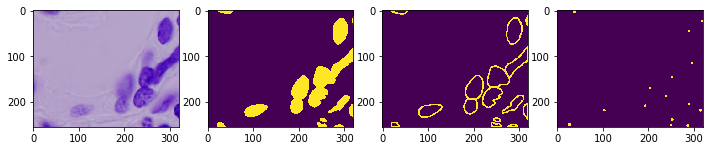

In [72]:
filepaths = meta[['file_path_image','file_path_mask','file_path_contours','file_path_centers']].values[172]
filepaths

image = plt.imread(filepaths[0])
mask = plt.imread(filepaths[1])
contour = plt.imread(filepaths[2]) 
center = plt.imread(filepaths[3])

plt.figure(figsize=(12,10))
plt.subplot(141)
plt.imshow(image)
plt.subplot(142)
plt.imshow(mask)
plt.subplot(143)
plt.imshow(contour)
plt.subplot(144)
plt.imshow(center)
plt.show()

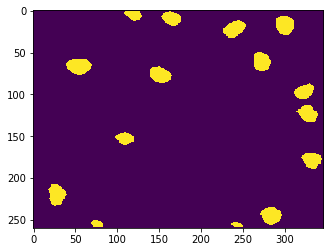

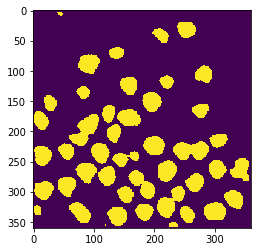

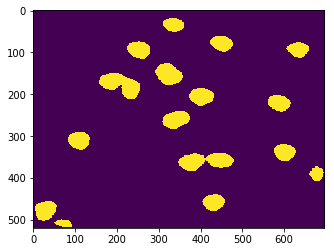

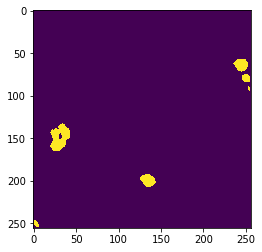

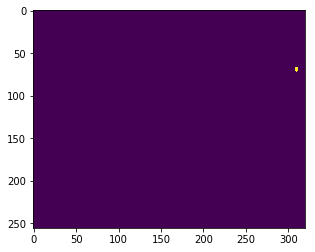

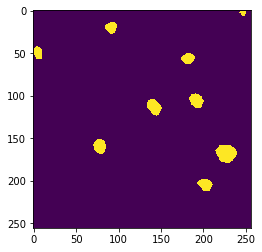

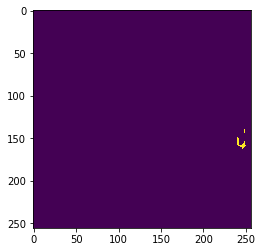

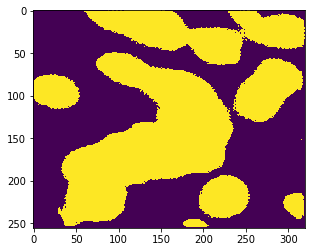

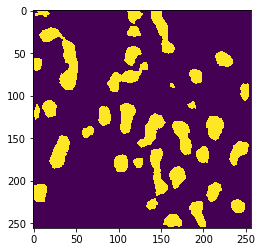

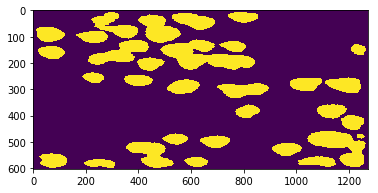

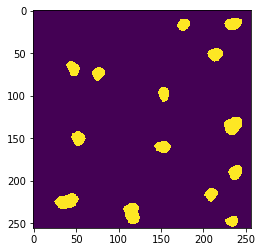

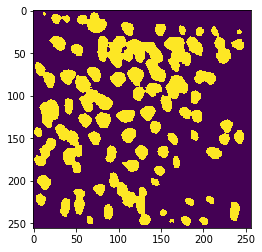

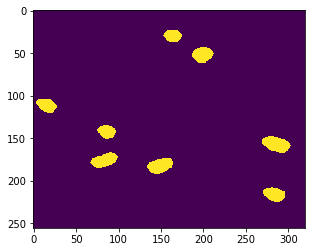

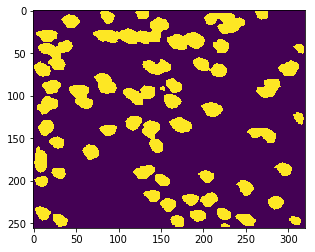

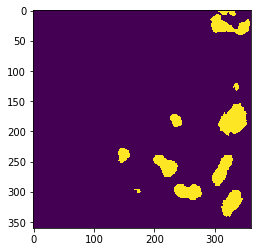

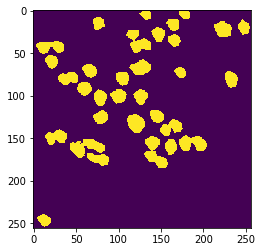

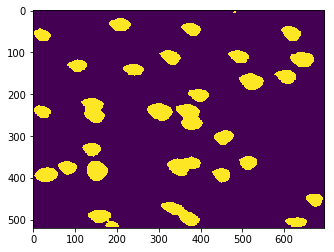

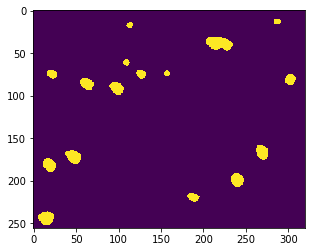

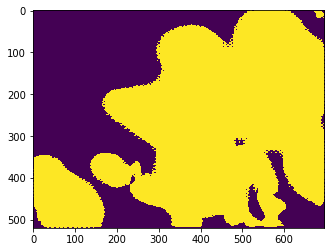

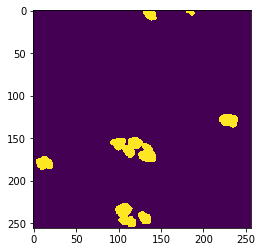

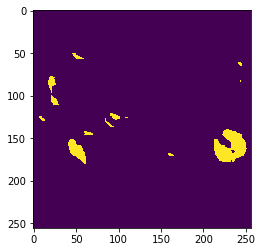

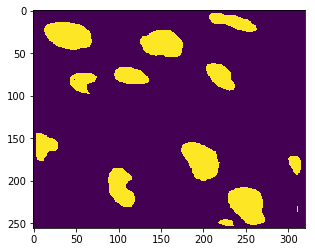

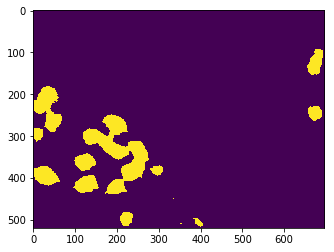

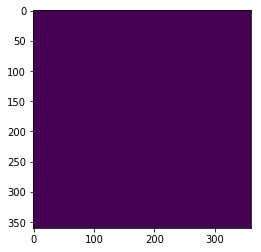

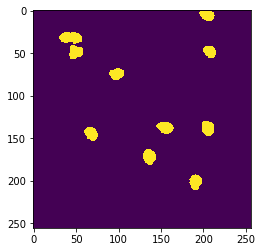

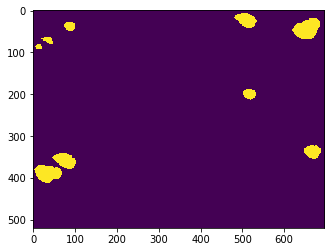

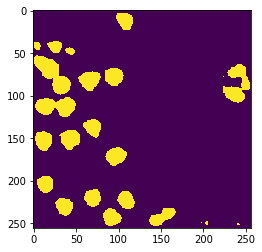

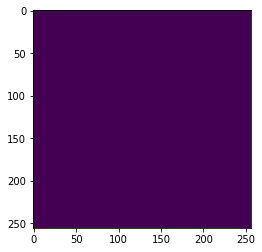

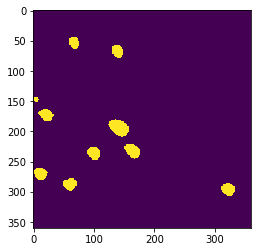

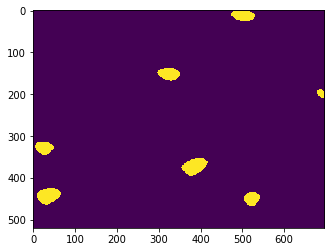

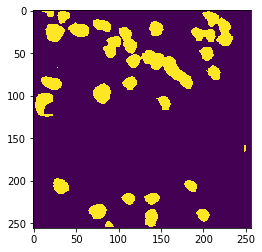

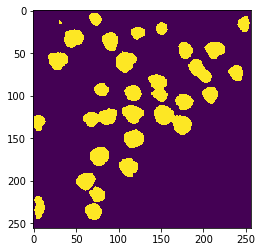

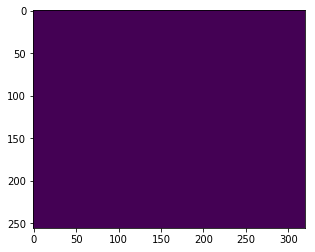

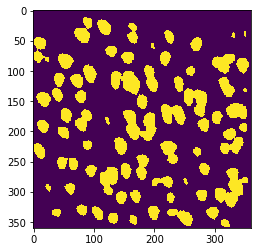

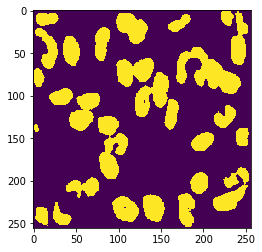

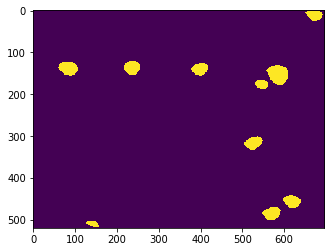

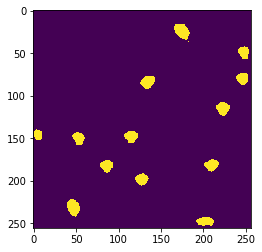

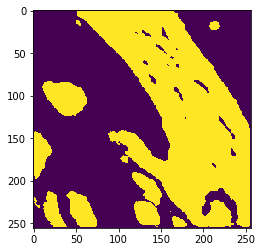

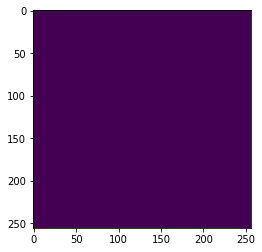

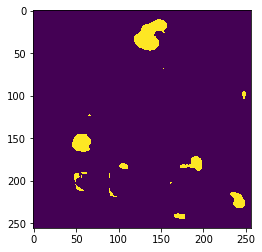

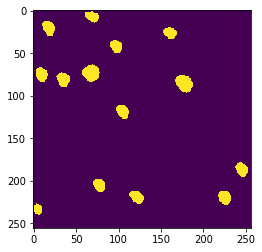

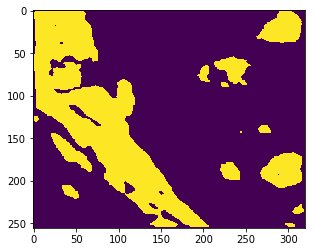

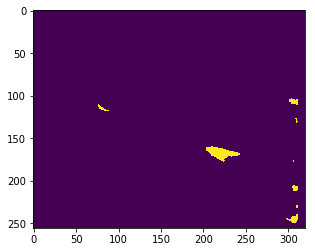

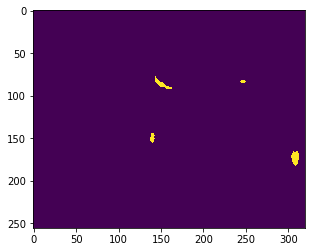

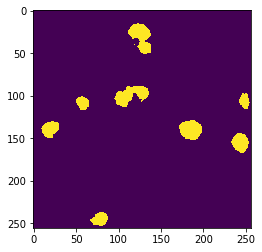

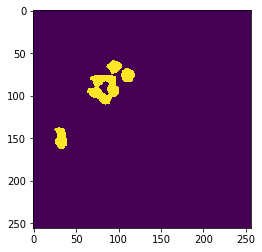

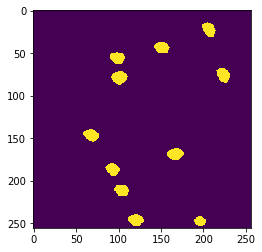

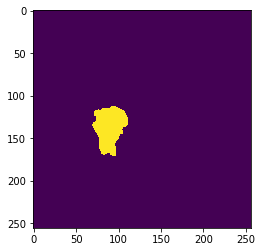

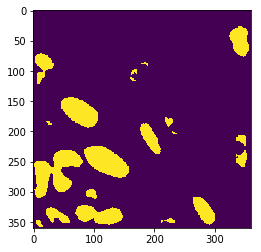

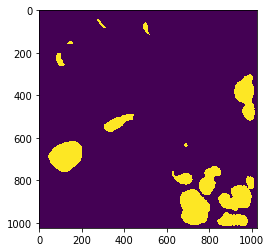

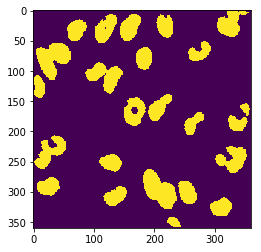

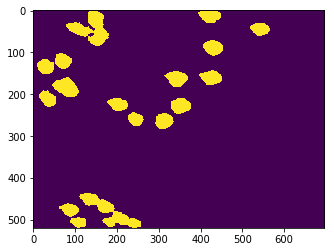

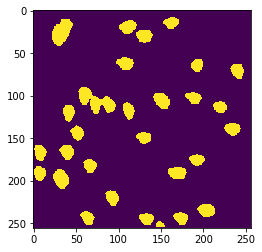

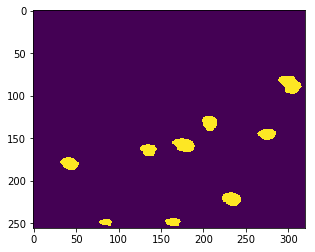

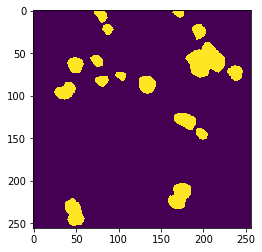

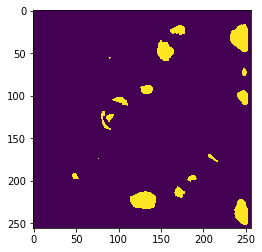

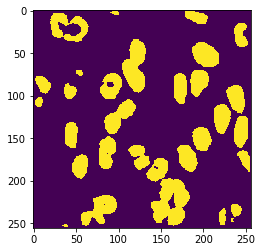

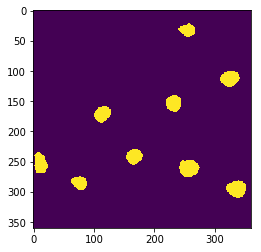

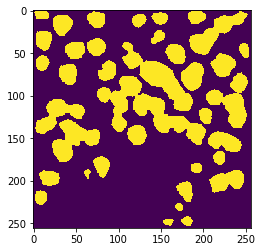

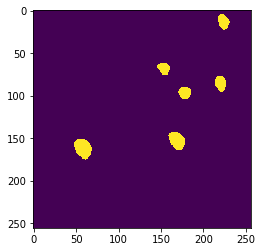

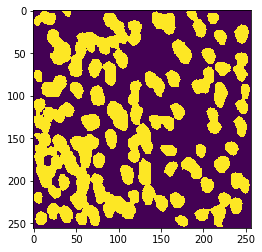

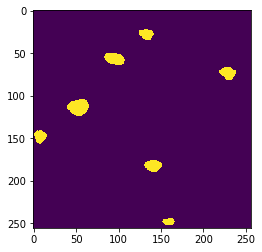

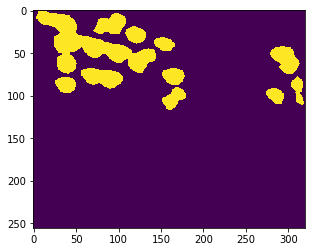

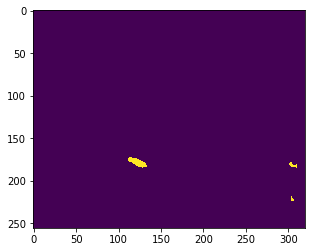

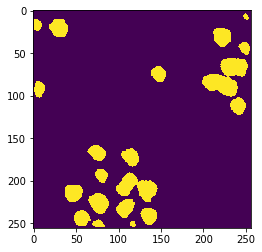

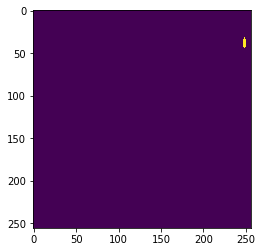

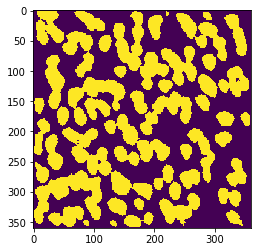

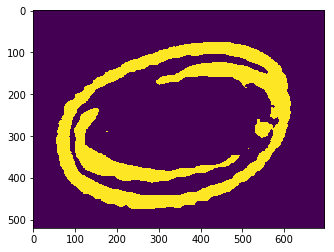

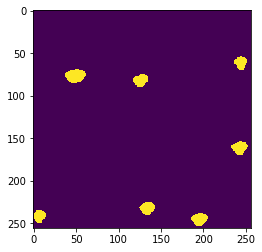

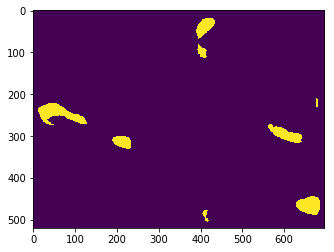

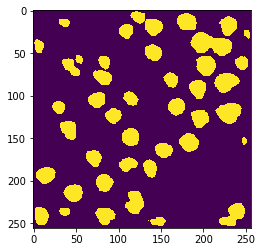

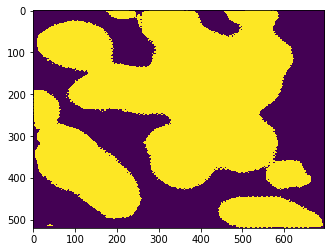

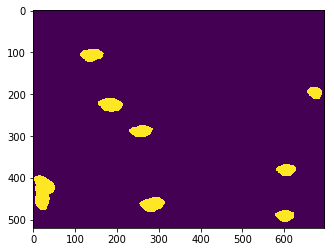

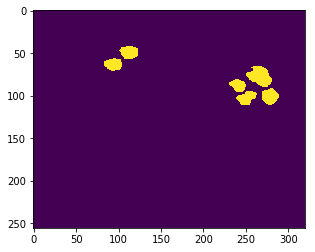

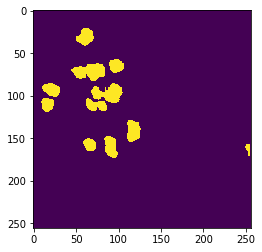

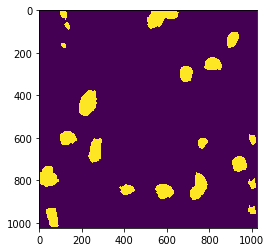

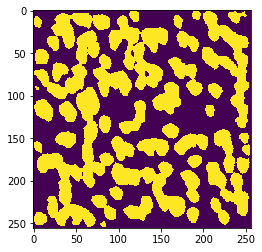

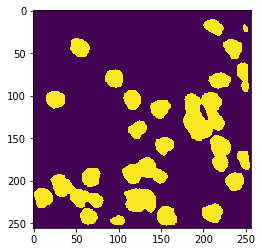

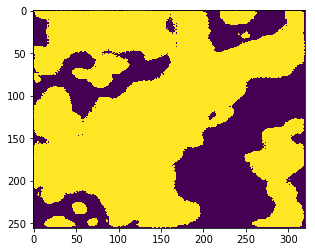

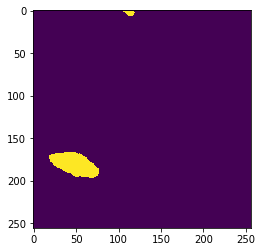

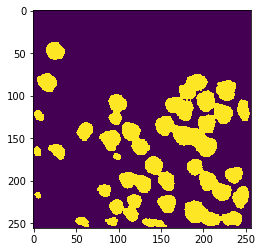

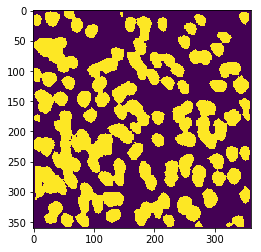

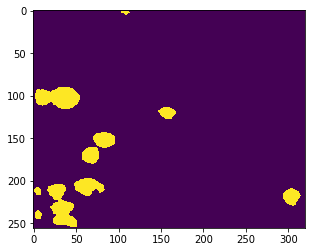

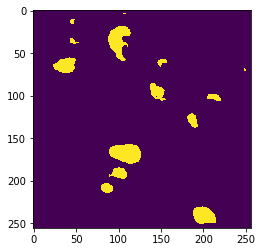

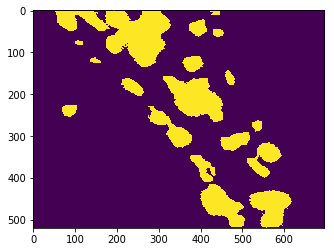

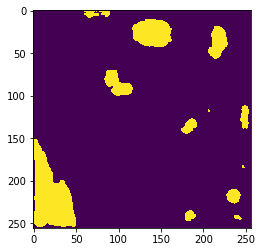

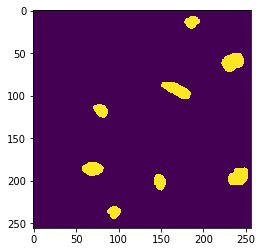

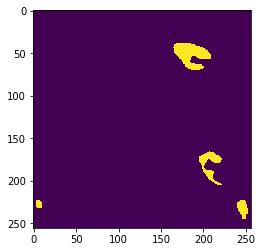

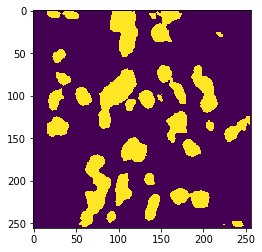

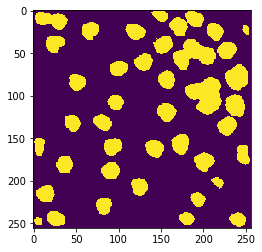

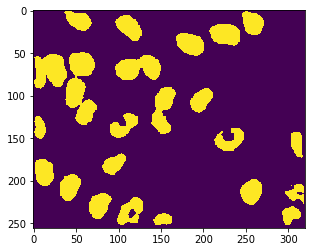

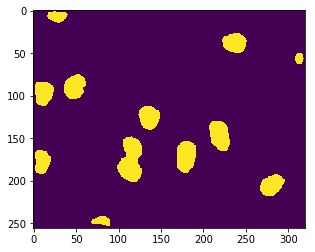

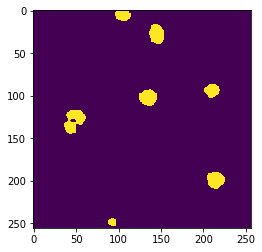

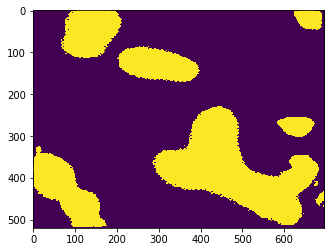

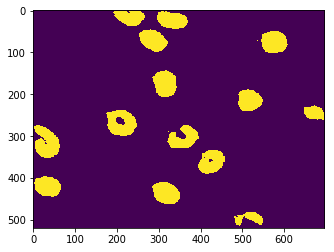

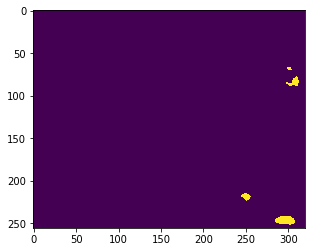

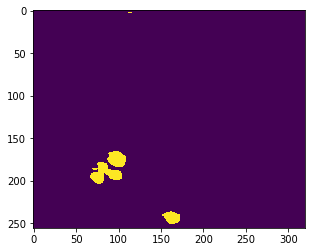

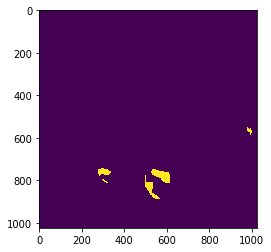

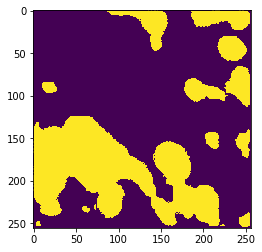

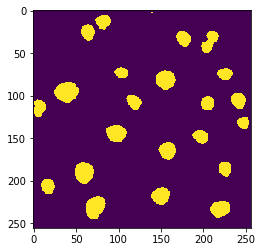

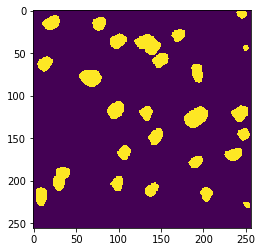

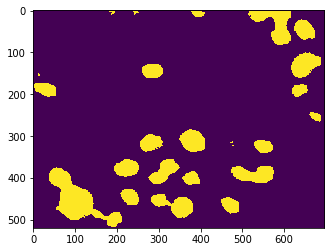

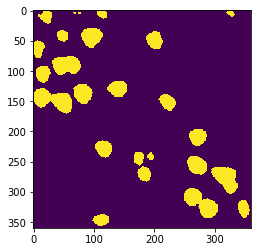

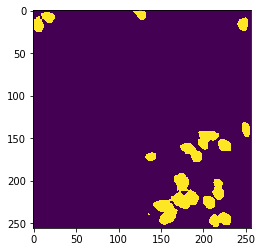

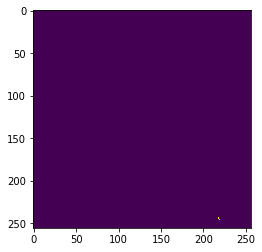

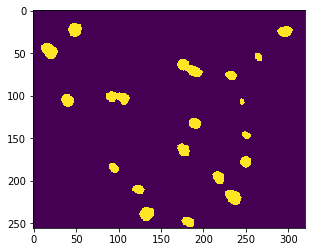

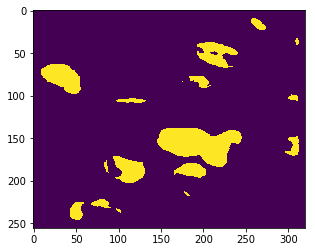

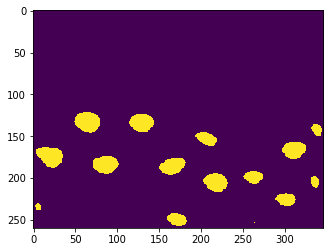

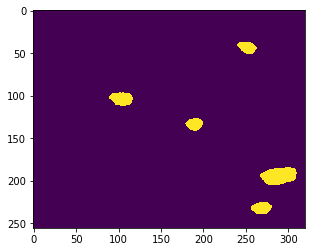

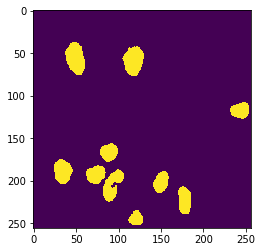

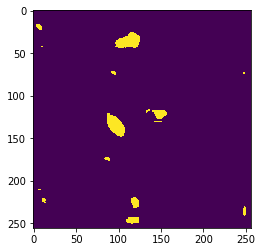

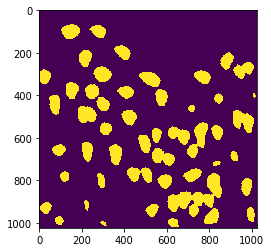

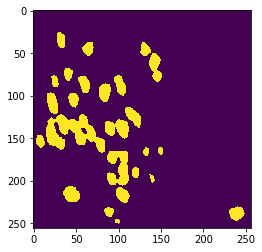

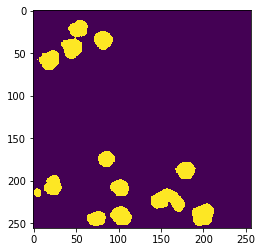

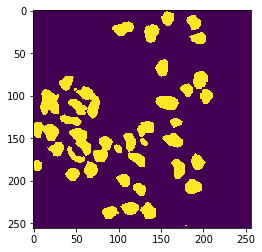

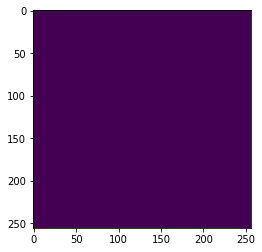

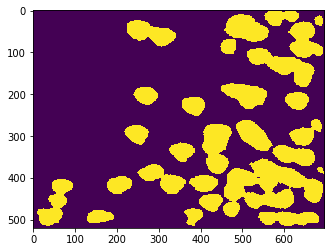

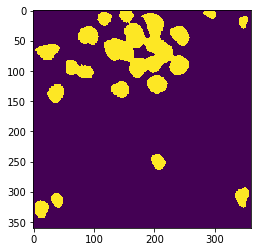

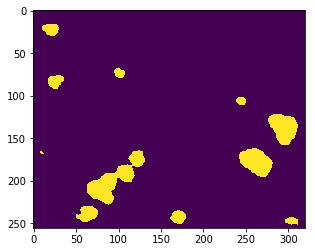

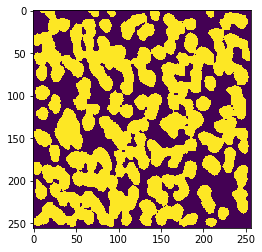

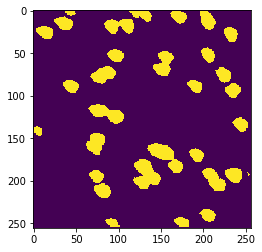

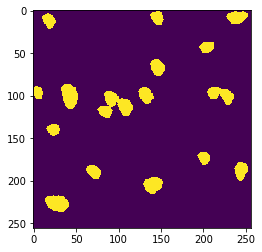

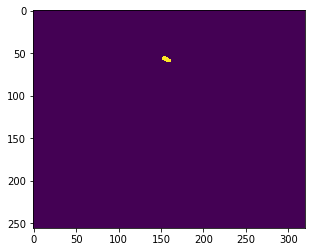

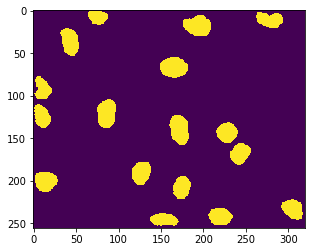

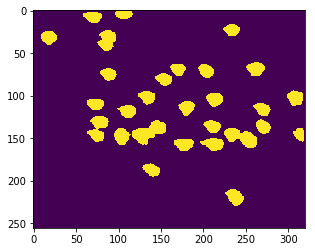

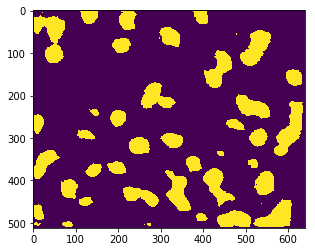

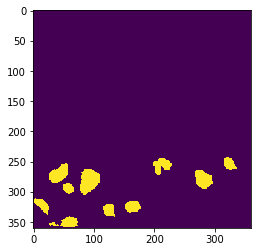

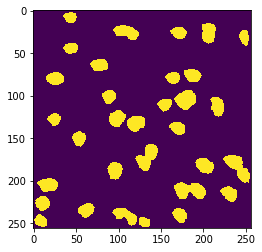

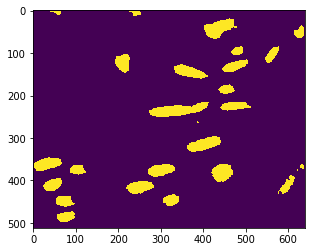

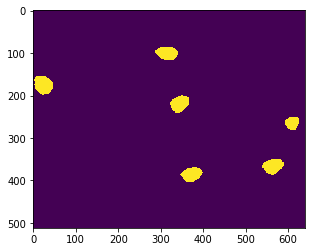

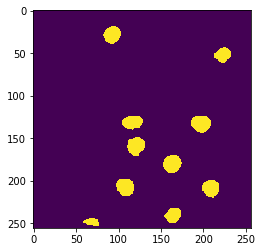

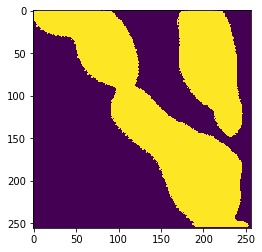

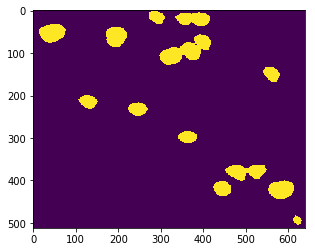

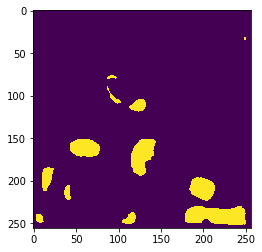

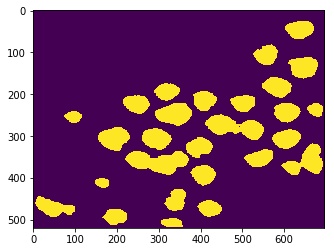

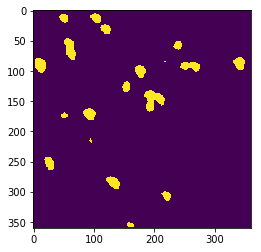

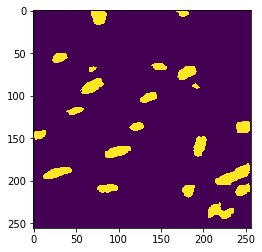

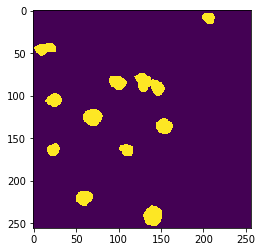

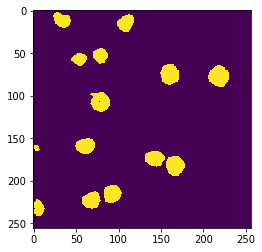

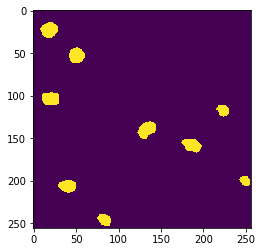

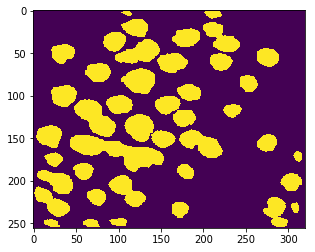

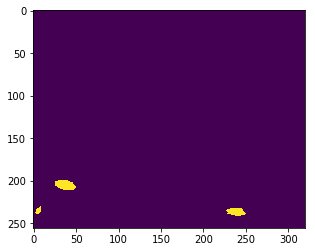

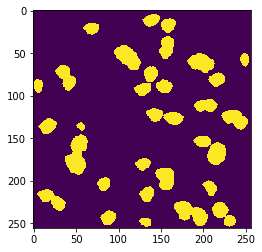

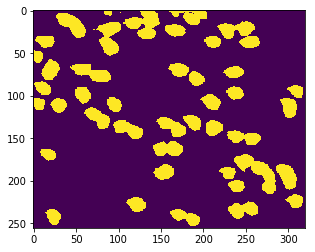

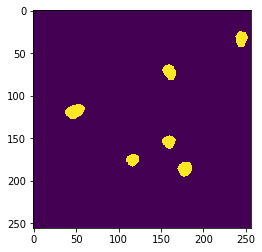

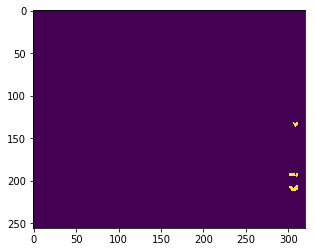

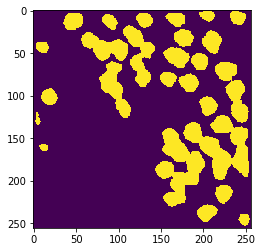

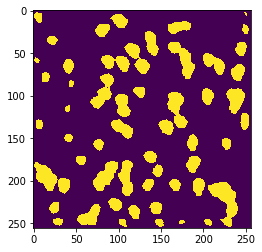

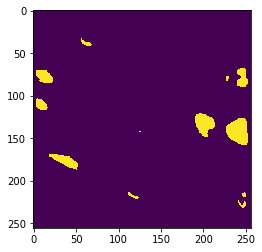

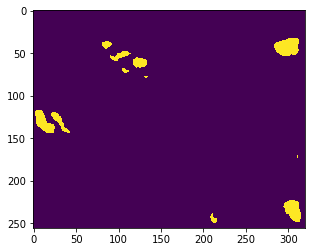

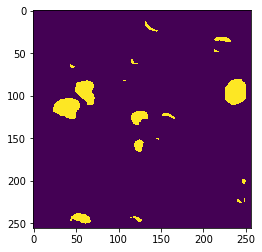

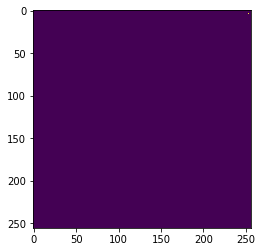

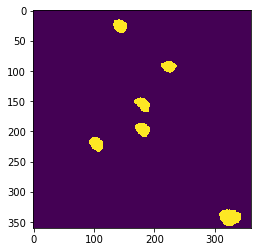

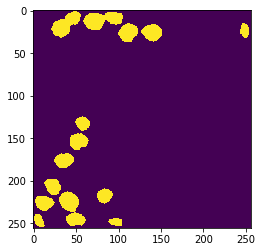

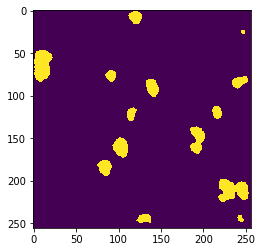

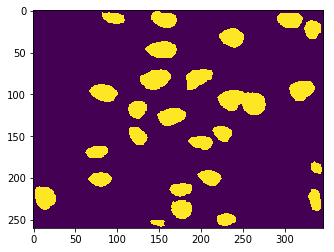

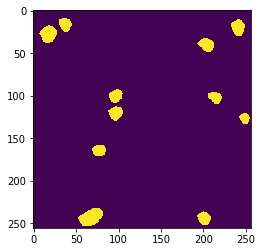

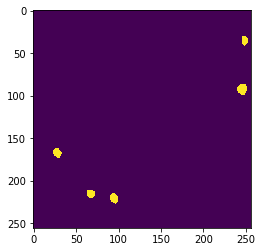

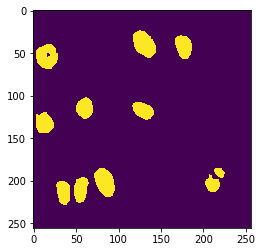

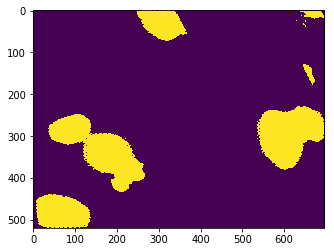

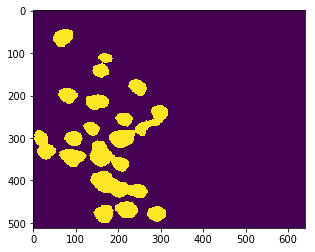

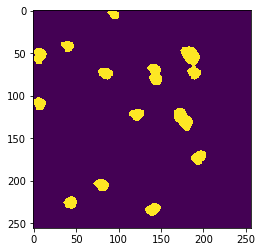

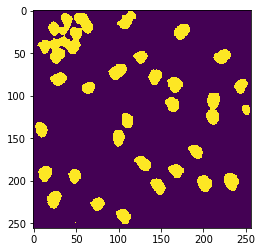

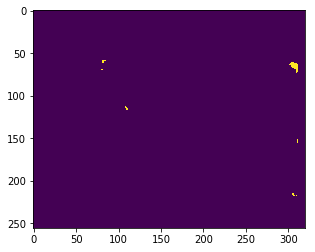

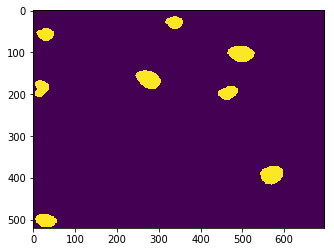

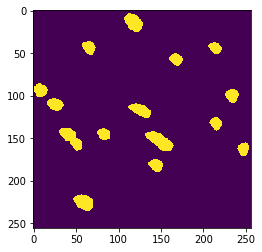

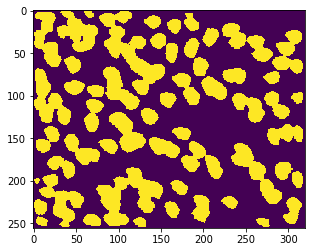

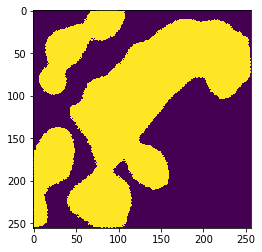

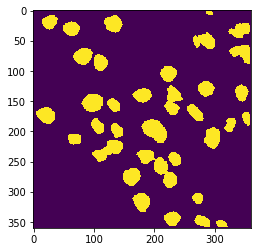

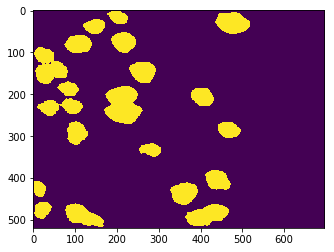

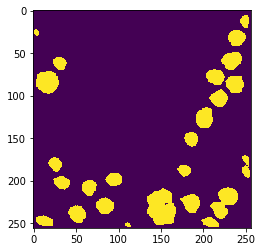

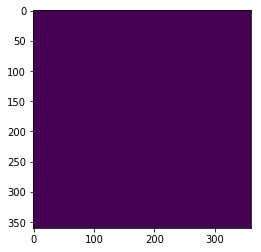

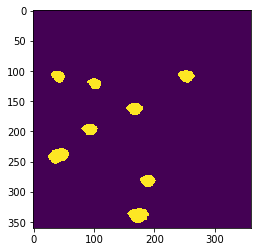

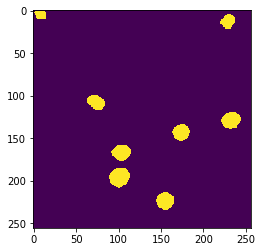

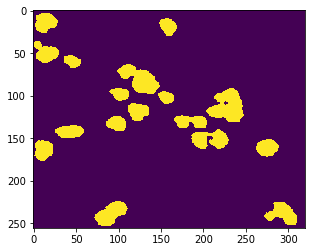

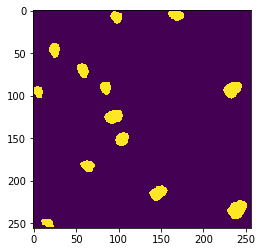

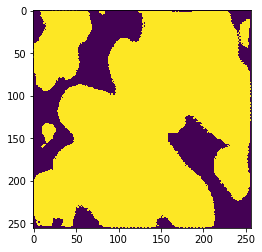

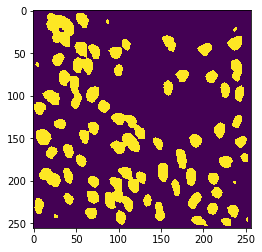

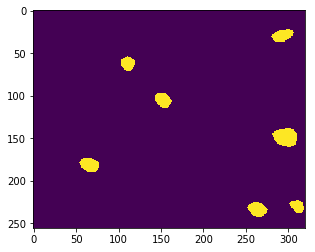

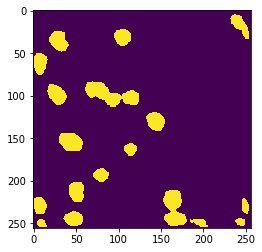

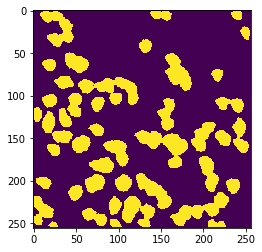

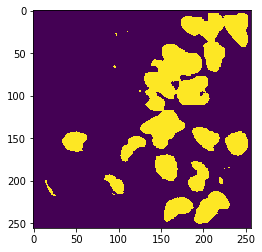

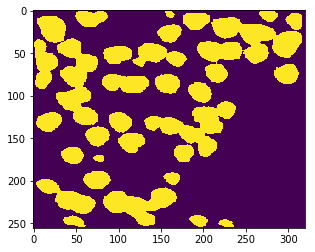

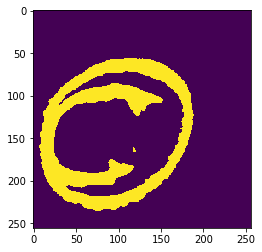

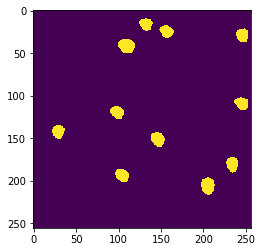

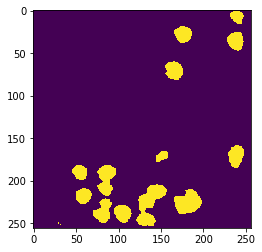

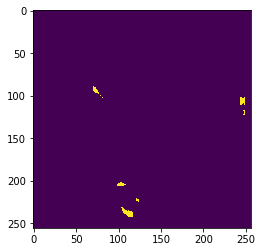

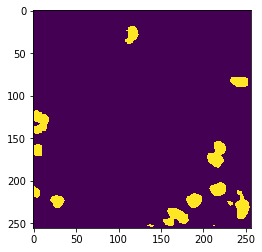

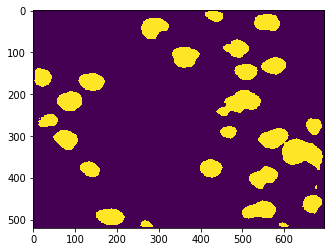

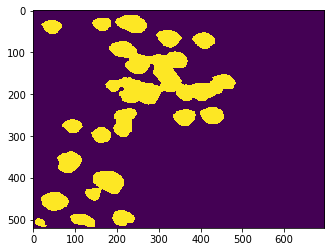

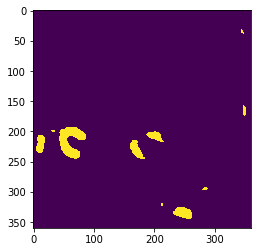

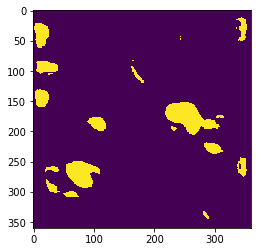

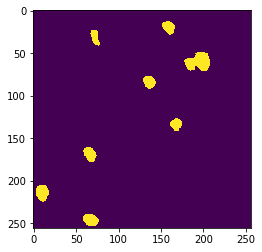

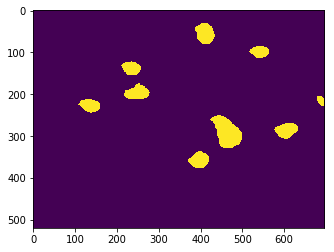

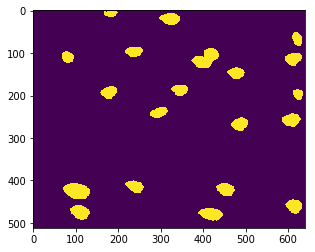

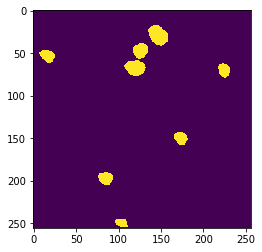

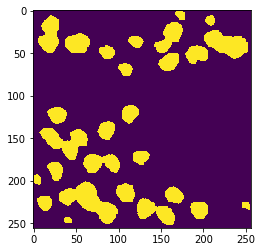

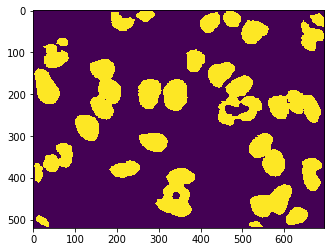

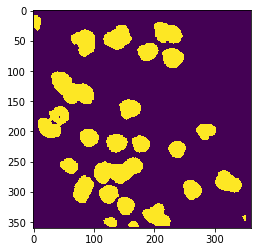

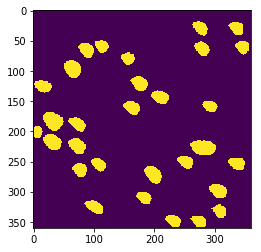

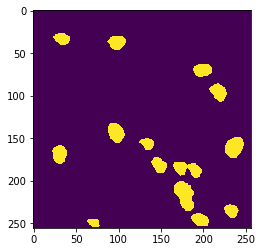

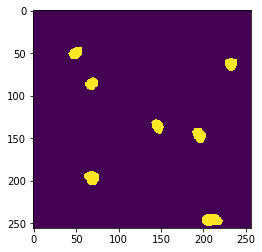

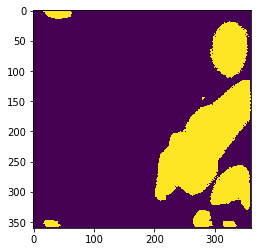

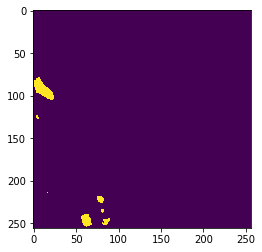

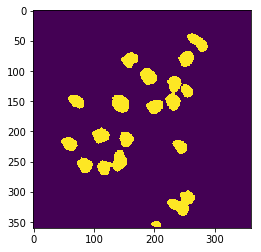

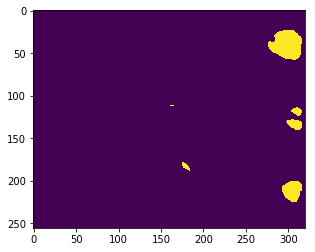

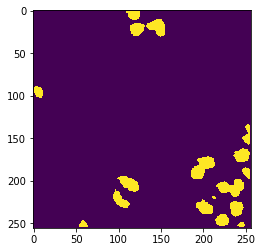

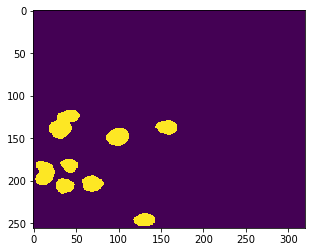

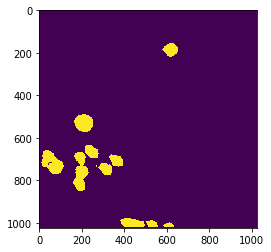

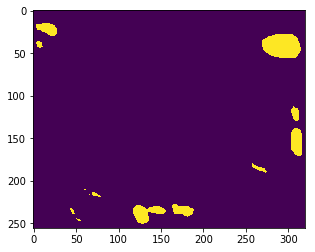

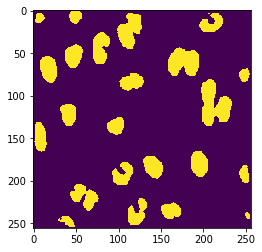

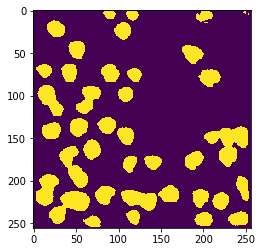

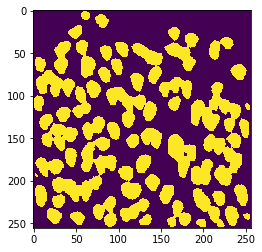

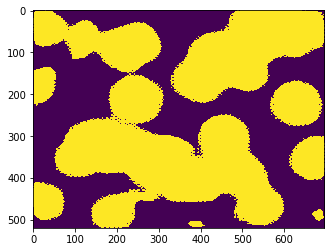

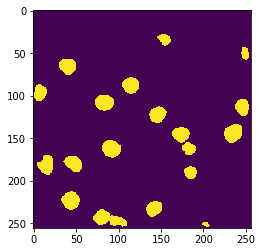

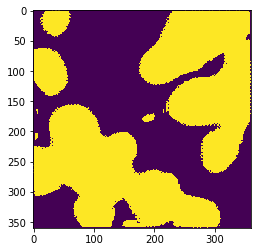

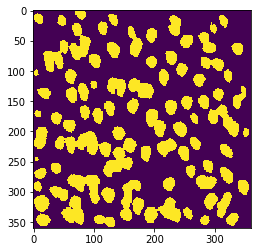

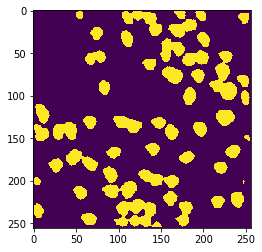

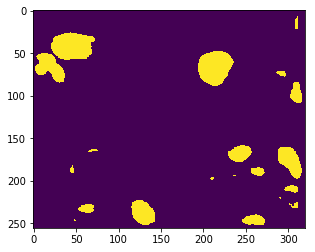

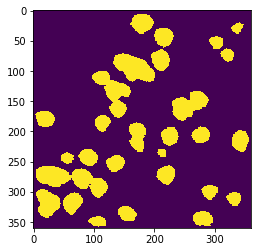

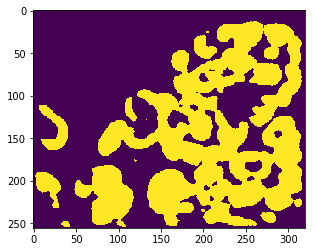

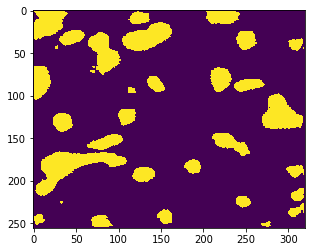

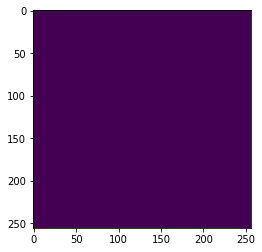

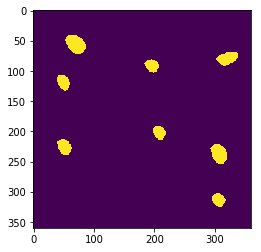

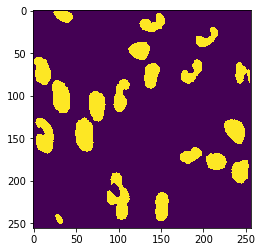

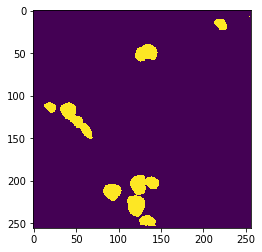

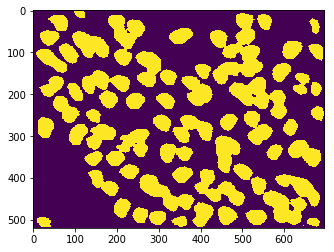

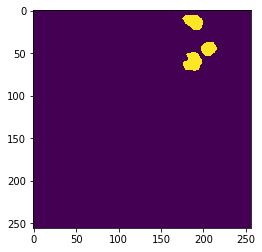

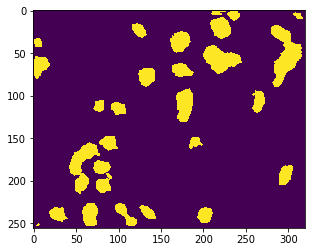

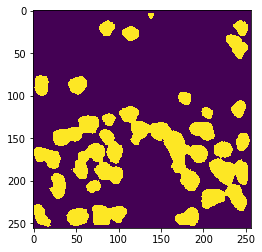

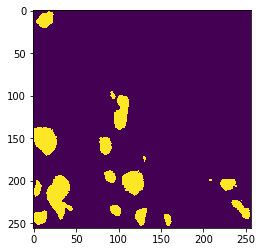

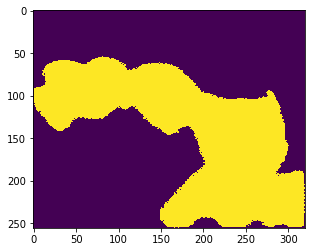

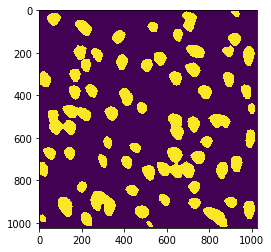

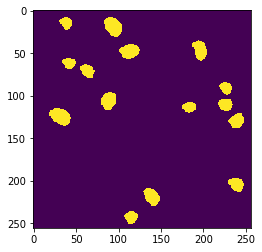

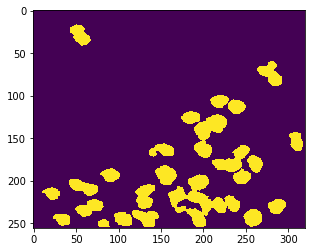

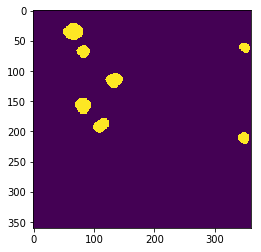

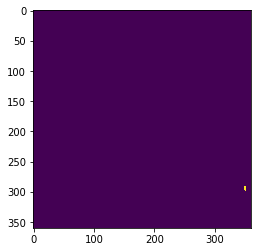

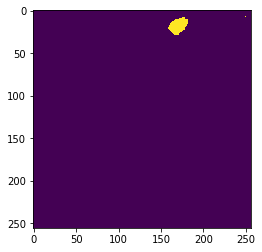

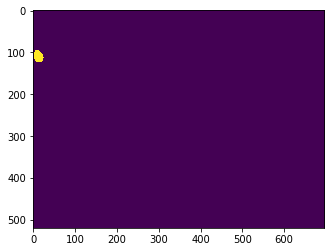

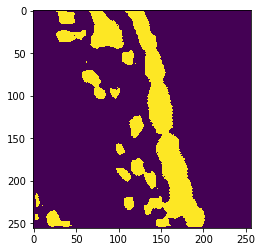

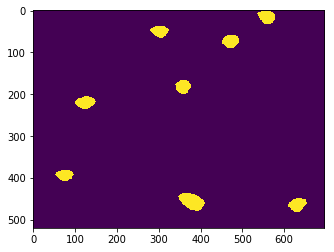

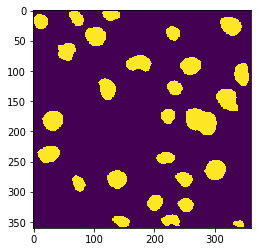

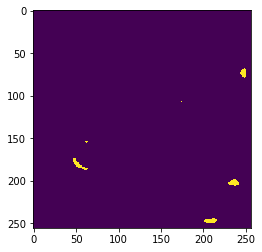

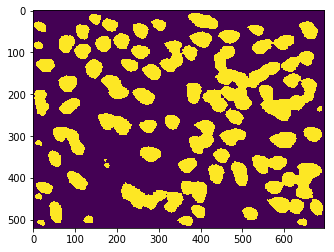

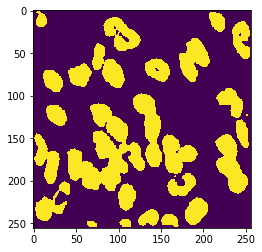

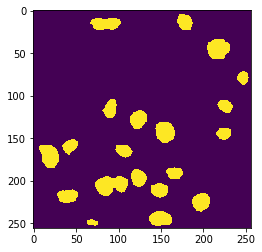

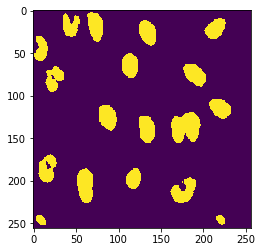

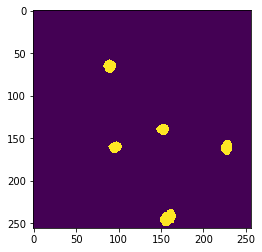

KeyboardInterrupt: 

In [78]:
masks = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_tripled_dev/outputs/contour_thresholding')
for mask in masks['binarized_images']:
    plt.imshow(mask)
    plt.show()

In [66]:
from scipy.stats import itemfreq
itemfreq(contour)

array([[  3.92156886e-03,   1.19107000e+05],
       [  1.25490203e-01,   1.03550000e+04],
       [  1.41176477e-01,   1.38000000e+02],
       [  2.66666681e-01,   1.19107000e+05],
       [  3.29411775e-01,   1.19107000e+05],
       [  5.49019635e-01,   1.03550000e+04],
       [  5.64705908e-01,   1.03550000e+04],
       [  9.05882359e-01,   1.38000000e+02],
       [  9.92156863e-01,   1.38000000e+02],
       [  1.00000000e+00,   1.29600000e+05]])